In [1]:
import sys
sys.path.insert(0, "../../..")
from paths import DATA_DIR, FIG_DIR

import numpy as np
import scipy.sparse as sp
import dynamo as dyn
import scvelo as scv

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.gridspec as gridspec
%matplotlib inline

from graphvelo.gam import fit_velo_peak
from graphvelo.graph_velocity import GraphVelo
from graphvelo.plot import gene_trend, plot_velocity_phase

/opt/anaconda3/envs/gv-reprod/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
scv.settings.figdir = str(FIG_DIR)
scv.settings.set_figure_params('scvelo', dpi_save=400, dpi=80, transparent=True, fontsize=20, color_map='viridis')
scv.settings.plot_prefix = ""

In [3]:
adata = dyn.read('adata_gv.h5ad')
adata

AnnData object with n_obs × n_vars = 9815 × 2000
    obs: 'sample', 'stage', 'sequencing.batch', 'theiler', 'celltype', 'initial_size_unspliced', 'initial_size_spliced', 'initial_size', 'n_counts', 'velocity_self_transition', 'root_cells', 'end_points', 'velocity_pseudotime', 'latent_time'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand', 'MURK_gene', 'Δm', 'scaled Δm', 'gene_count_corr', 'means', 'dispersions', 'dispersions_norm', 'highly_variable', 'fit_r2', 'fit_alpha', 'fit_beta', 'fit_gamma', 'fit_t_', 'fit_scaling', 'fit_std_u', 'fit_std_s', 'fit_likelihood', 'fit_u0', 'fit_s0', 'fit_pval_steady', 'fit_steady_u', 'fit_steady_s', 'fit_variance', 'fit_alignment_scaling', 'velocity_genes', 'mack_score'
    uns: 'celltype_colors', 'gv_params', 'log1p', 'neighbors', 'pca', 'recover_dynamics', 'velocity_graph', 'velocity_graph_neg', 'velocity_params'
    obsm: 'X_pca', 'X_umap', 'gv_pca', 'gv_umap', 'velocity_umap'
    varm: 'PCs', 'loss'
    layers: 'Ms', 'Mu', 'fit_t', 'f

In [4]:
color_map = {
    'Blood progenitors 1': '#f9decf',
    'Blood progenitors 2': '#c9a997',
    'Erythroid1': '#c72228', 
    'Erythroid2': '#f79083', 
    'Erythroid3': '#ef4e22'
}

In [7]:
adata_dyn = adata.copy()
dyn.tl.scv_dyn_convertor(adata_dyn)

|-----> Dynamo and scvelo have different preprocessing procedures and velocity estimation methods. The conversion of adata may not be optimal for every use case, requiring potential manual adjustments.
|-----> Start converting Scvelo adata into Dynamo adata...
|-----> Scvelo data wil be converted into Dynamo adata with the conventional assumption and thestochastic model. If this is not what you want, please change them manually.


AnnData object with n_obs × n_vars = 9815 × 2000
    obs: 'sample', 'stage', 'sequencing.batch', 'theiler', 'celltype', 'initial_size_unspliced', 'initial_size_spliced', 'initial_size', 'n_counts', 'velocity_self_transition', 'root_cells', 'end_points', 'velocity_pseudotime', 'latent_time'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand', 'MURK_gene', 'Δm', 'scaled Δm', 'gene_count_corr', 'means', 'dispersions', 'dispersions_norm', 'fit_t_', 'fit_scaling', 'fit_std_u', 'fit_std_s', 'fit_likelihood', 'fit_pval_steady', 'fit_steady_u', 'fit_steady_s', 'fit_variance', 'fit_alignment_scaling', 'velocity_genes', 'mack_score', 'use_for_pca'
    uns: 'celltype_colors', 'gv_params', 'log1p', 'neighbors', 'pca', 'velocity_graph', 'velocity_graph_neg', 'velocity_params', 'dynamics', 'pp', 'vel_params_names'
    obsm: 'X_pca', 'X_umap', 'gv_pca', 'gv_umap', 'velocity_umap'
    varm: 'PCs', 'loss', 'vel_params'
    layers: 'fit_t', 'fit_tau', 'fit_tau_', 'velocity_gv', 'X_spliced', 'X_

In [8]:
adata_dyn.layers['M_s'] = sp.csr_matrix(adata_dyn.layers['M_s'])
adata_dyn.layers['velocity_S'] = sp.csr_matrix(adata_dyn.layers['velocity_gv'])
adata_dyn.obsm['velocit_umap'] = adata_dyn.obsm['gv_umap']

In [9]:
adata_dyn = dyn.pp.pca(adata_dyn)
gv = GraphVelo(adata_dyn, xkey='M_s', vkey='velocity_S')
adata_dyn.layers['velocity_U'] = gv.project_velocity(adata_dyn.layers['M_u'], adata.obsp['gv'])
adata_dyn.obsm['velocity_pca'] = gv.project_velocity(adata_dyn.obsm['X_pca'], adata.obsp['gv'])
del gv

|-----> <insert> X_pca to obsm in AnnData Object.


projecting velocity vector to low dimensional embedding: 100%|██████████| 9815/9815 [00:01<00:00, 5530.42it/s]
projecting velocity vector to low dimensional embedding: 100%|██████████| 9815/9815 [00:00<00:00, 17841.85it/s]


In [8]:
dyn.vf.VectorField(adata_dyn, basis='pca', M=1500, pot_curl_div=True)

|-----> VectorField reconstruction begins...
|-----> Retrieve X and V based on basis: PCA. 
        Vector field will be learned in the PCA space.
|-----> Learning vector field with method: sparsevfc.
|-----> [SparseVFC] begins...
|-----> Sampling control points based on data velocity magnitude...
|-----> method arg is None, choosing methods automatically...
|-----------> method ball_tree selected
|-----> [SparseVFC] completed [32.7663s]
|-----> Running ddhodge to estimate vector field based pseudotime in pca basis...
|-----> graphizing vectorfield...
|-----------> calculating neighbor indices...
|-----> method arg is None, choosing methods automatically...
|-----------> method ball_tree selected
|-----------> not all cells are used, set diag to 1...
|-----------> Constructing W matrix according upsampling=True and downsampling=True options...
|-----> [ddhodge completed] completed [40.4378s]
|-----> Computing divergence...


Calculating divergence: 100%|██████████| 10/10 [00:06<00:00,  1.44it/s]

|-----> [VectorField] completed [80.6196s]


|-----------> plotting with basis key=X_umap


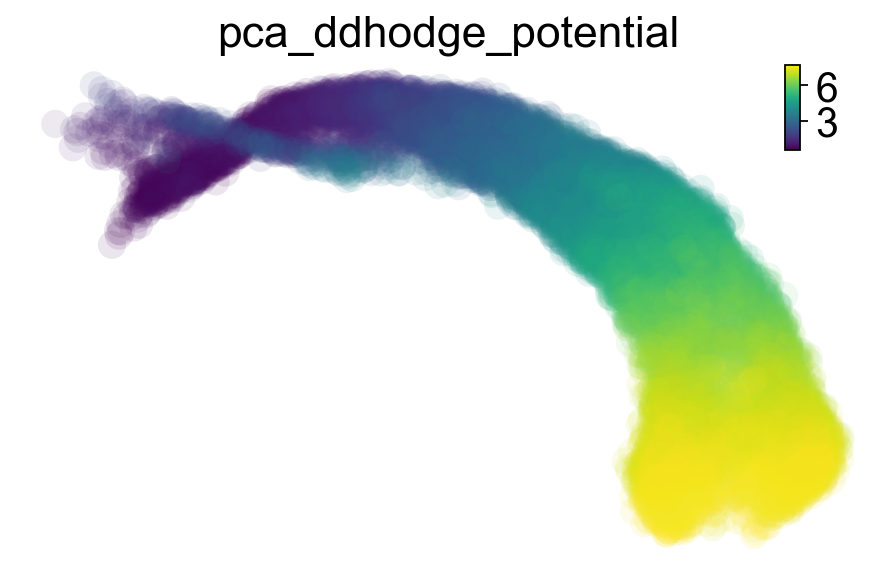

In [9]:
dyn.pl.scatters(adata_dyn, color=['pca_ddhodge_potential'])

In [10]:
res = fit_velo_peak(adata_dyn, tkey='pca_ddhodge_potential', genes=adata_dyn.var_names, layer='velocity_gv', log_norm=False)
res.head(5)

Identify velocity peaks using GAM: 100%|██████████| 2000/2000 [00:40<00:00, 49.61it/s]


phase  magnitude
Arfgef1  5.979247   0.000342
Tram1    0.384318   0.026173
Bag2     5.640467   0.005762
Uggt1    8.195443   0.002052
Rev1     5.871231  -0.005804

In [55]:
cluster_df = adata_dyn.obs[['pca_ddhodge_potential', 'celltype']]
t_min, t_max = cluster_df['pca_ddhodge_potential'].values.min(), cluster_df['pca_ddhodge_potential'].values.max()
n_bins=100
n_clusters = len(color_map)
clusters = list(color_map.keys())
bin_edges = np.linspace(t_min, t_max, n_bins + 1)
density = np.zeros((n_clusters, n_bins))

for i, cl in enumerate(clusters):
    # Extract t values for cells belonging to celltype cl
    t_vals = cluster_df.loc[cluster_df['celltype'] == cl, 'pca_ddhodge_potential'].values

    # Bin the t values
    hist, _ = np.histogram(t_vals, bins=bin_edges)
    
    # Convert raw counts to a 0-1 scale (e.g., fraction of the celltype's max bin)
    if hist.max() > 0:
        density[i] = hist / hist.max()

# 5) Build an RGBA array for imshow: shape (n_clusters, n_bins, 4)
color_array = np.ones((n_clusters, n_bins, 4))  # start with all ones (white + alpha=1)

# Convert hex -> (r, g, b)
cluster_rgb = {cl: mcolors.to_rgb(color_map[cl]) for cl in clusters}

# Fill each row with the base color, alpha set by density
for i, cl in enumerate(clusters):
    r, g, b = cluster_rgb[cl]
    color_array[i, :, 0] = r
    color_array[i, :, 1] = g
    color_array[i, :, 2] = b
    color_array[i, :, 3] = density[i]  # alpha channel from 0 -> 1

In [56]:
res['color'] = ['red' if i in adata_dyn[:, adata_dyn.var['MURK_gene']].var_names else 'lightgrey' for i in res.index]
res['MURK'] = adata_dyn[:, res.index].var['MURK_gene'].values

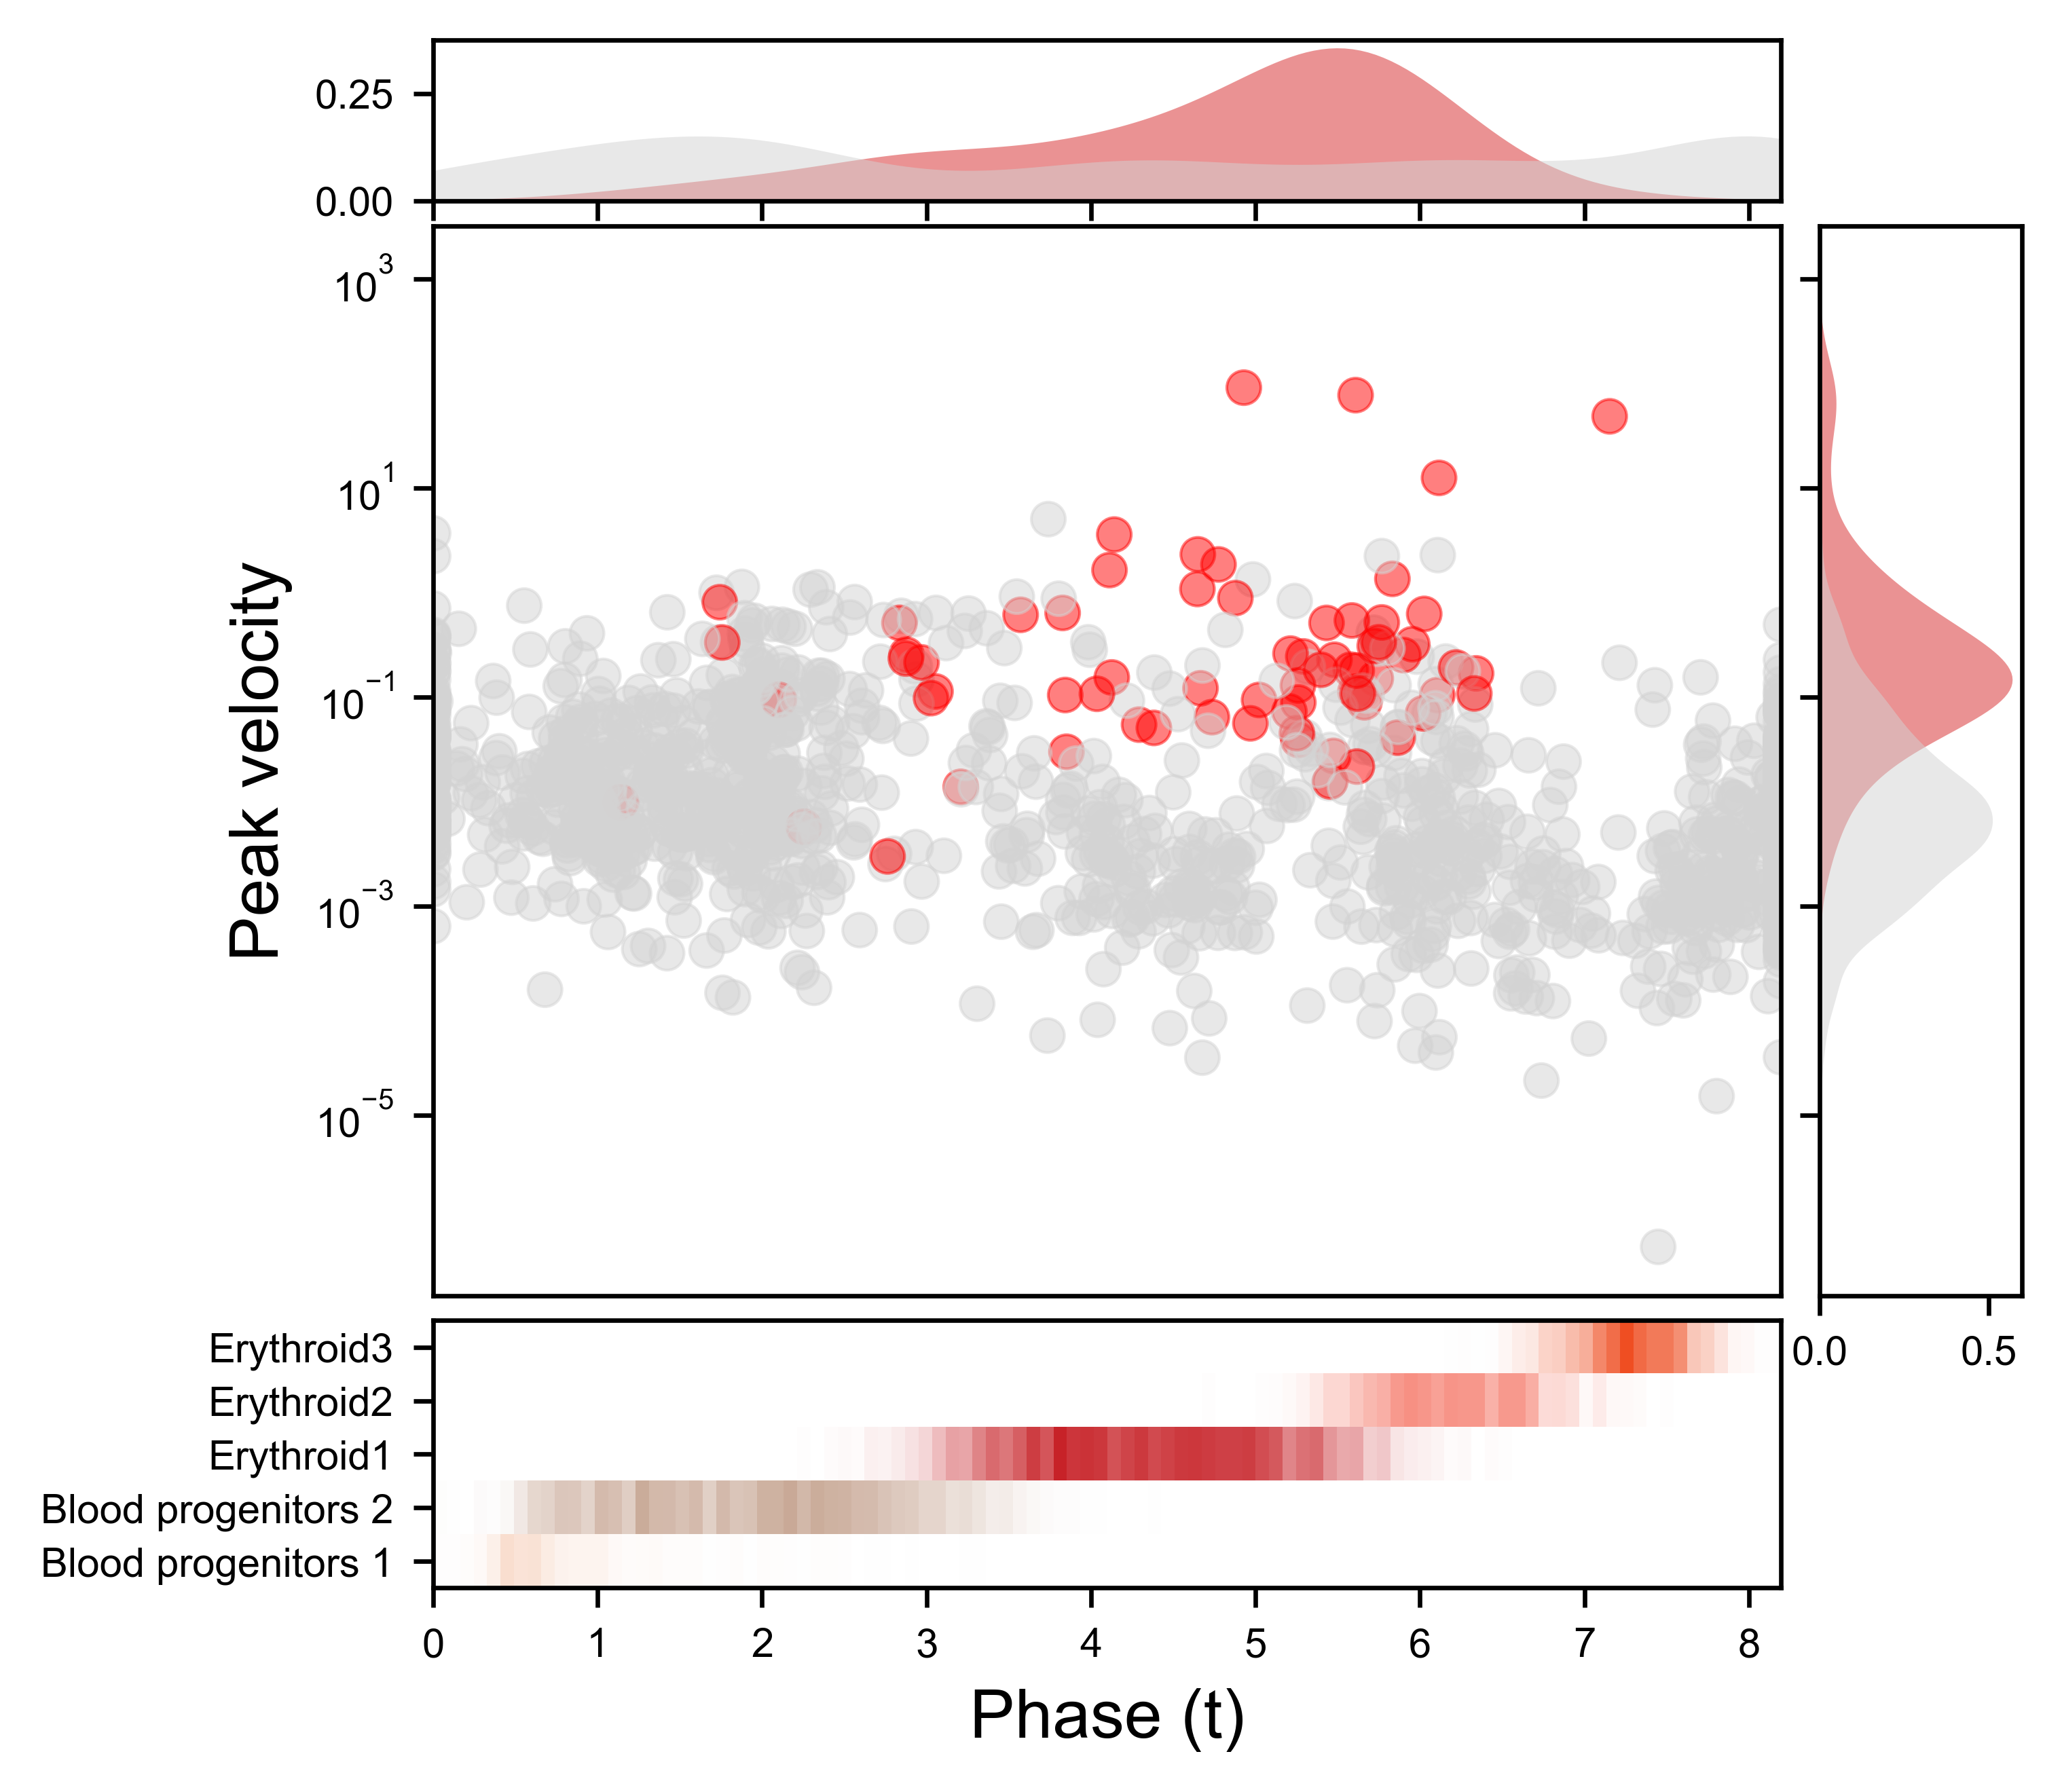

In [57]:
palette_murk = {True: '#d62728', False: '#d3d3d3'}
fig = plt.figure(figsize=(5, 5), dpi=300)
gs = gridspec.GridSpec(3, 2, height_ratios=[0.6, 4, 1], width_ratios=[4, 0.6], hspace=0.05, wspace=0.05)
ax_main = fig.add_subplot(gs[1, 0])
ax_top = fig.add_subplot(gs[0, 0], sharex=ax_main)
ax_side = fig.add_subplot(gs[1, 1], sharey=ax_main)
ax_bar = fig.add_subplot(gs[2, 0], sharex=ax_main)

ax_main.scatter(res["phase"].values, res["magnitude"].values, c=res['color'], alpha=0.5)
ax_main.set_ylabel('Peak velocity', fontsize=12)
ax_main.legend(frameon=False)
ax_main.xaxis.set_visible(False)

sns.kdeplot(
    res,
    x='phase', hue='MURK', palette=palette_murk, common_norm=False, alpha=.5, linewidth=0,
    ax=ax_top, fill=True, legend=False
)
ax_top.tick_params(labelbottom=False)
ax_top.set_ylabel("")  # no label
ax_top.set_xlabel("")  # no label
# for spine in ax_top.spines.values():
#     spine.set_visible(False)

sns.kdeplot(res, 
            y='magnitude', hue='MURK', palette=palette_murk, ax=ax_side, fill=True, common_norm=False, alpha=.5, linewidth=0, legend=False, log_scale=True)
ax_side.tick_params(labelleft=False)
ax_side.set_ylabel("")
ax_side.set_xlabel("")
# for spine in ax_side.spines.values():
#     spine.set_visible(False)

ax_bar.imshow(
    color_array,
    aspect='auto',       # stretch each row to fill the x-range
    origin='lower',      # row 0 at bottom
    extent=[t_min, t_max, 0, n_clusters]
)

# 7) Format the axes
ax_bar.sharex(ax_main)
ax_bar.set_ylim(0, n_clusters)

# Place celltype labels at the center of each row
ax_bar.set_yticks(np.arange(n_clusters) + 0.5)
ax_bar.set_yticklabels(clusters)

ax_bar.set_xlabel('Phase (t)', fontsize=12)
plt.savefig('velo_peak_.pdf', dpi=300, transparent=True)
plt.show()

In [54]:
res.sort_values('magnitude', ascending=False).head(10)

phase  magnitude      color   MURK
Hbb-bh1  4.929282  91.758126        red   True
Hba-x    5.608886  77.814135        red   True
Hbb-y    7.153758  48.781715        red   True
Hba-a2   6.116237  12.560467        red   True
Fth1     3.740652   5.063031  lightgrey  False
Pfn1     0.000004   3.705446  lightgrey  False
Prdx2    4.141427   3.603352        red   True
Gpx1     4.649590   2.329527        red   True
Car2     6.108467   2.292306  lightgrey  False
Hbb-bs   5.768726   2.242478  lightgrey  False

In [5]:
selected_genes = ['Fth1', 'Car2', 'Hbb-bs']

Plotting velocity in phase diagram: 100%|██████████| 3/3 [00:04<00:00,  1.62s/it]


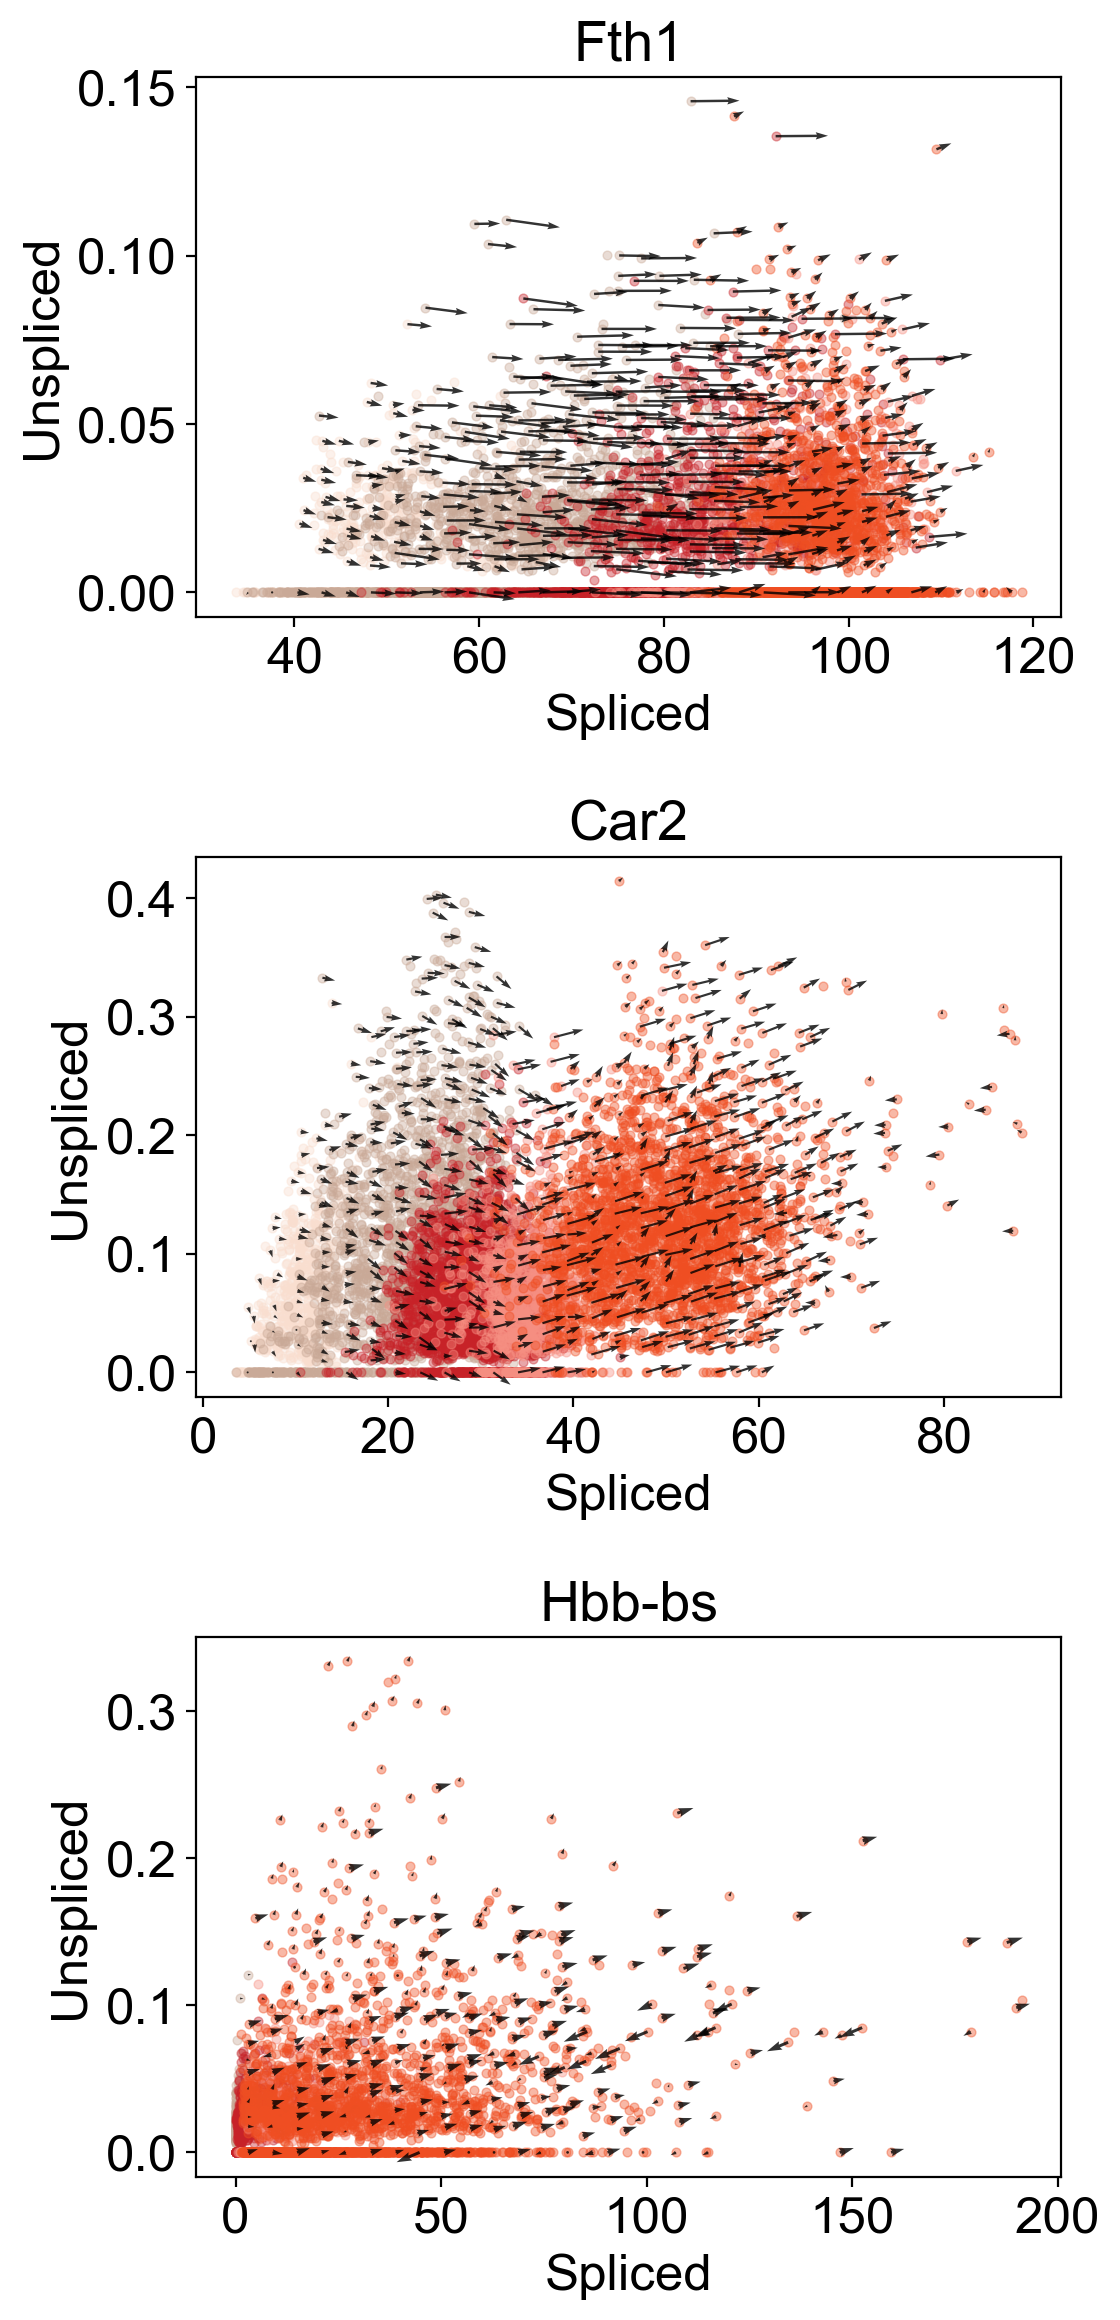

In [15]:
kwargs = {'genes': selected_genes, 'color': 'celltype',
          'pointsize': 10, 'ncols': 1, 'scale': 0.8, 'downsample': 0.1, 'quiver_alpha': 0.8, 'show': False}
ax = plot_velocity_phase(adata_dyn, **kwargs)
# plt.savefig(str(FIG_DIR)+'/suppl_figures_mouse_ery/predict_murk.pdf', dpi=300, transparent=True)
plt.show()

saving figure to file /Users/yuhaochen/Documents/GitHub/graphvelo_reproducibility/figures/suppl_figures_mouse_ery/predict_murk.pdf


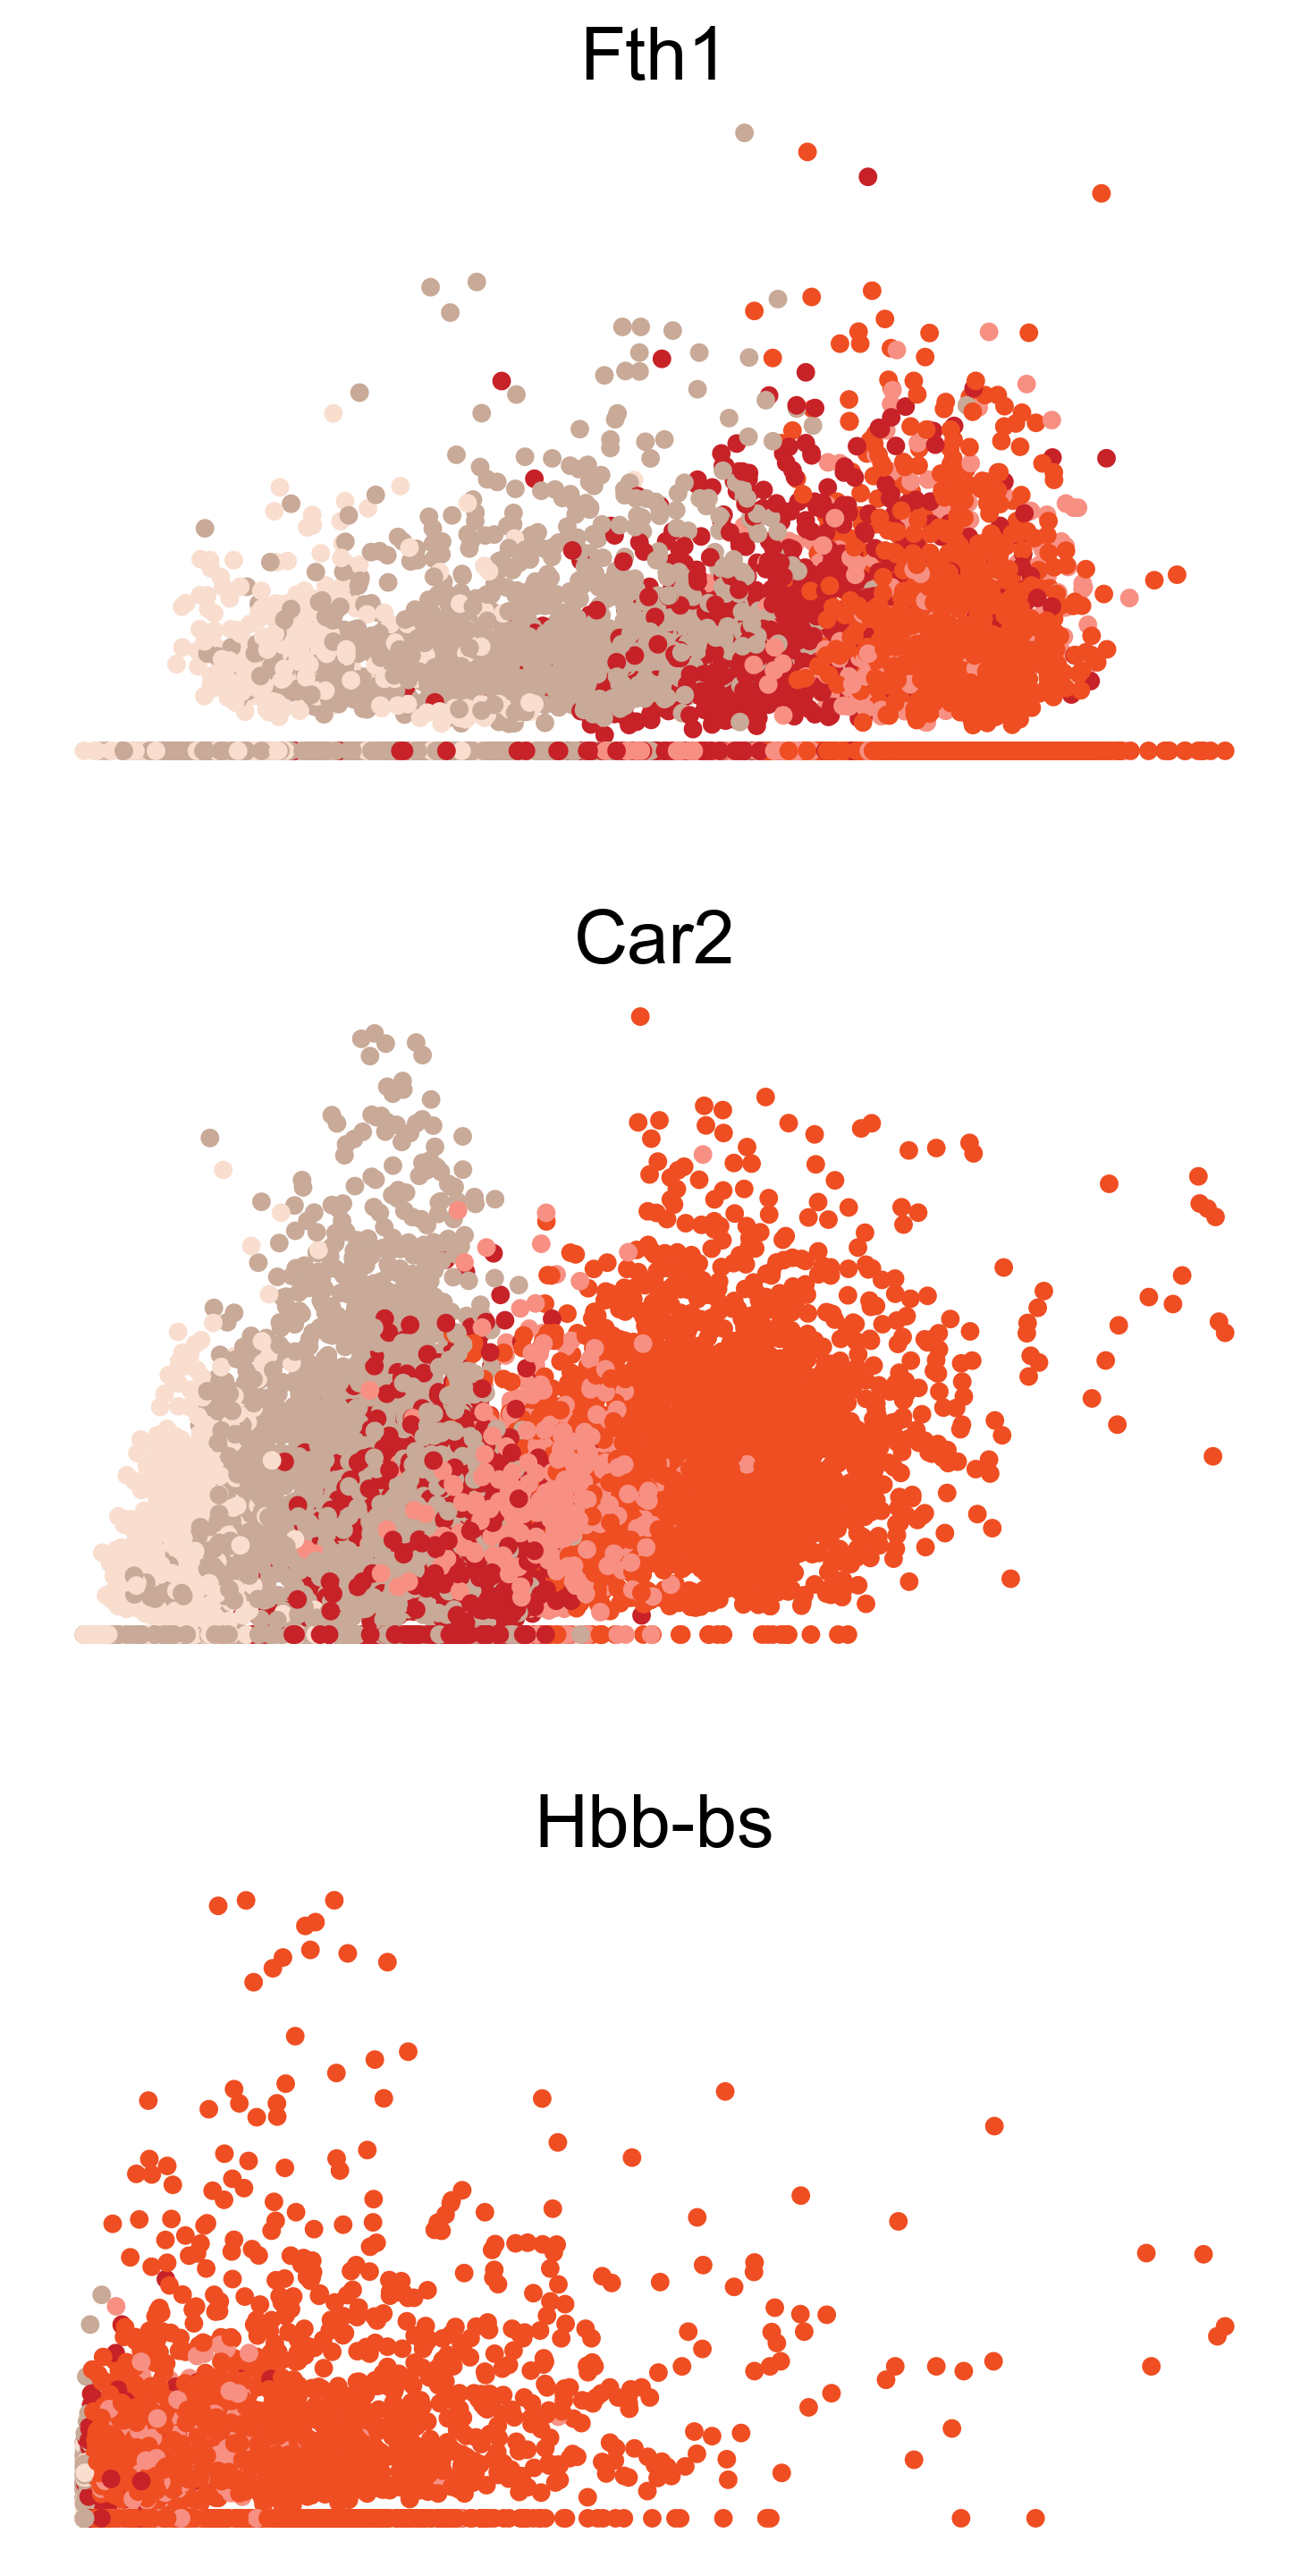

In [78]:
fig_kwargs = {'basis': selected_genes, 'color': 'celltype', 'ncols': 1, 'frameon': False, 's': 100, 'dpi': 150}
fig_kwargs['save'] = scv.settings.figdir + '/suppl_figures_mouse_ery/predict_murk.pdf'
scv.pl.scatter(adata, **fig_kwargs)

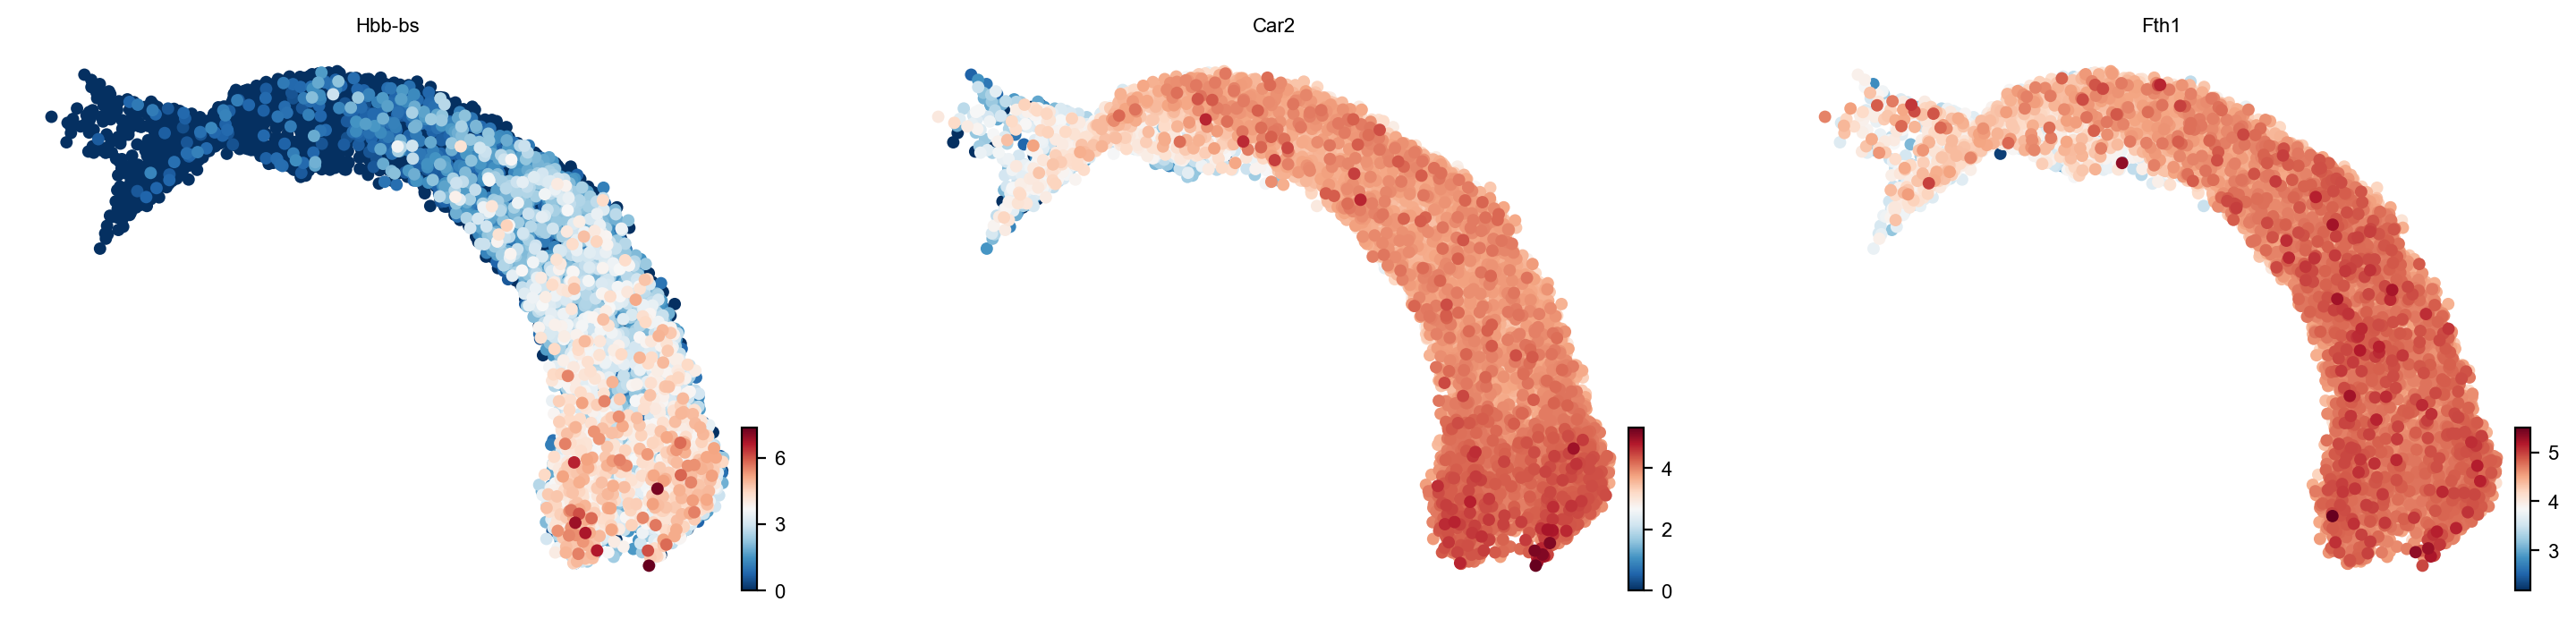

In [72]:
fig_kwargs = {'color': selected_genes, 'size': 100}
# if save_figure: fig_kwargs['save'] = scv.settings.figdir +'suppl_figures_pancreas/suppl_fig_annotations/initial_terminal_markers.pdf'
scv.pl.scatter(adata_dyn, **fig_kwargs)

Fitting trends using GAM: 100%|██████████| 3/3 [00:00<00:00, 14.12it/s]


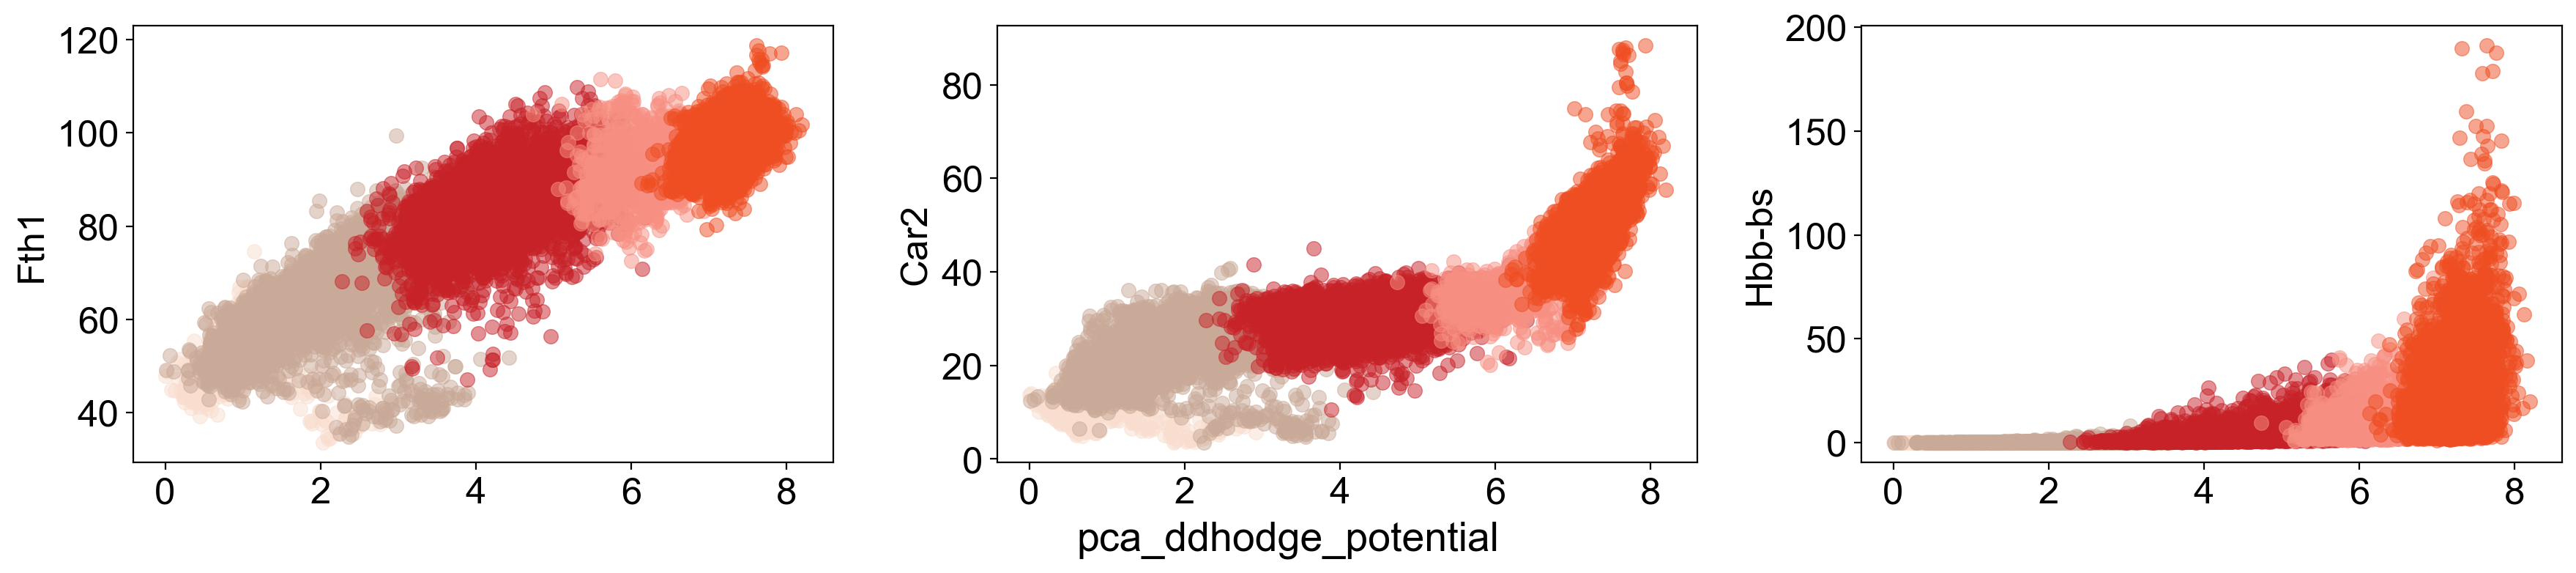

In [85]:
gene_trend(adata_dyn, layer='M_s', genes=selected_genes, tkey='pca_ddhodge_potential', color='celltype', pointsize=50, hide_interval=True, hide_trend=True)
plt.savefig(scv.settings.figdir + '/suppl_figures_mouse_ery/predict_murk_gene_trend.pdf', dpi=300, transparent=True,  bbox_inches='tight')

Fitting trends using GAM: 100%|██████████| 3/3 [00:00<00:00, 20.23it/s]


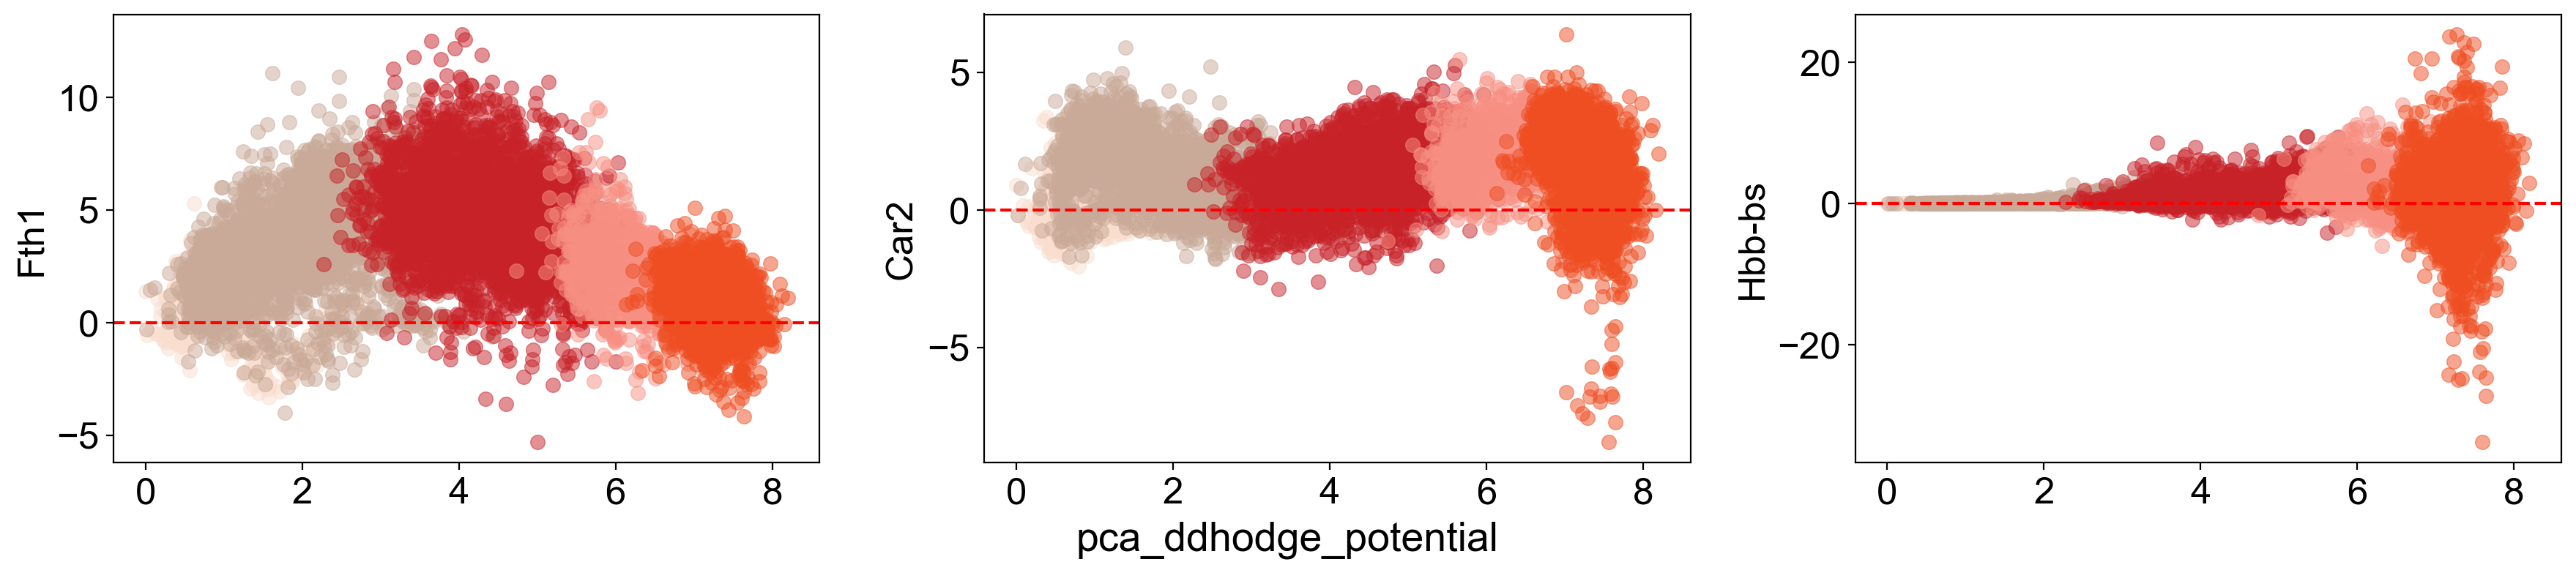

In [86]:
gene_trend(adata_dyn, layer='velocity_gv', genes=selected_genes, tkey='pca_ddhodge_potential', color='celltype', pointsize=50, zero_indicator=True, hide_interval=True, hide_trend=True)
plt.savefig(scv.settings.figdir + '/suppl_figures_mouse_ery/predict_murk_velo_trend.pdf', dpi=300, transparent=True,  bbox_inches='tight')

Plotting velocity in phase diagram: 100%|██████████| 5/5 [00:07<00:00,  1.52s/it]


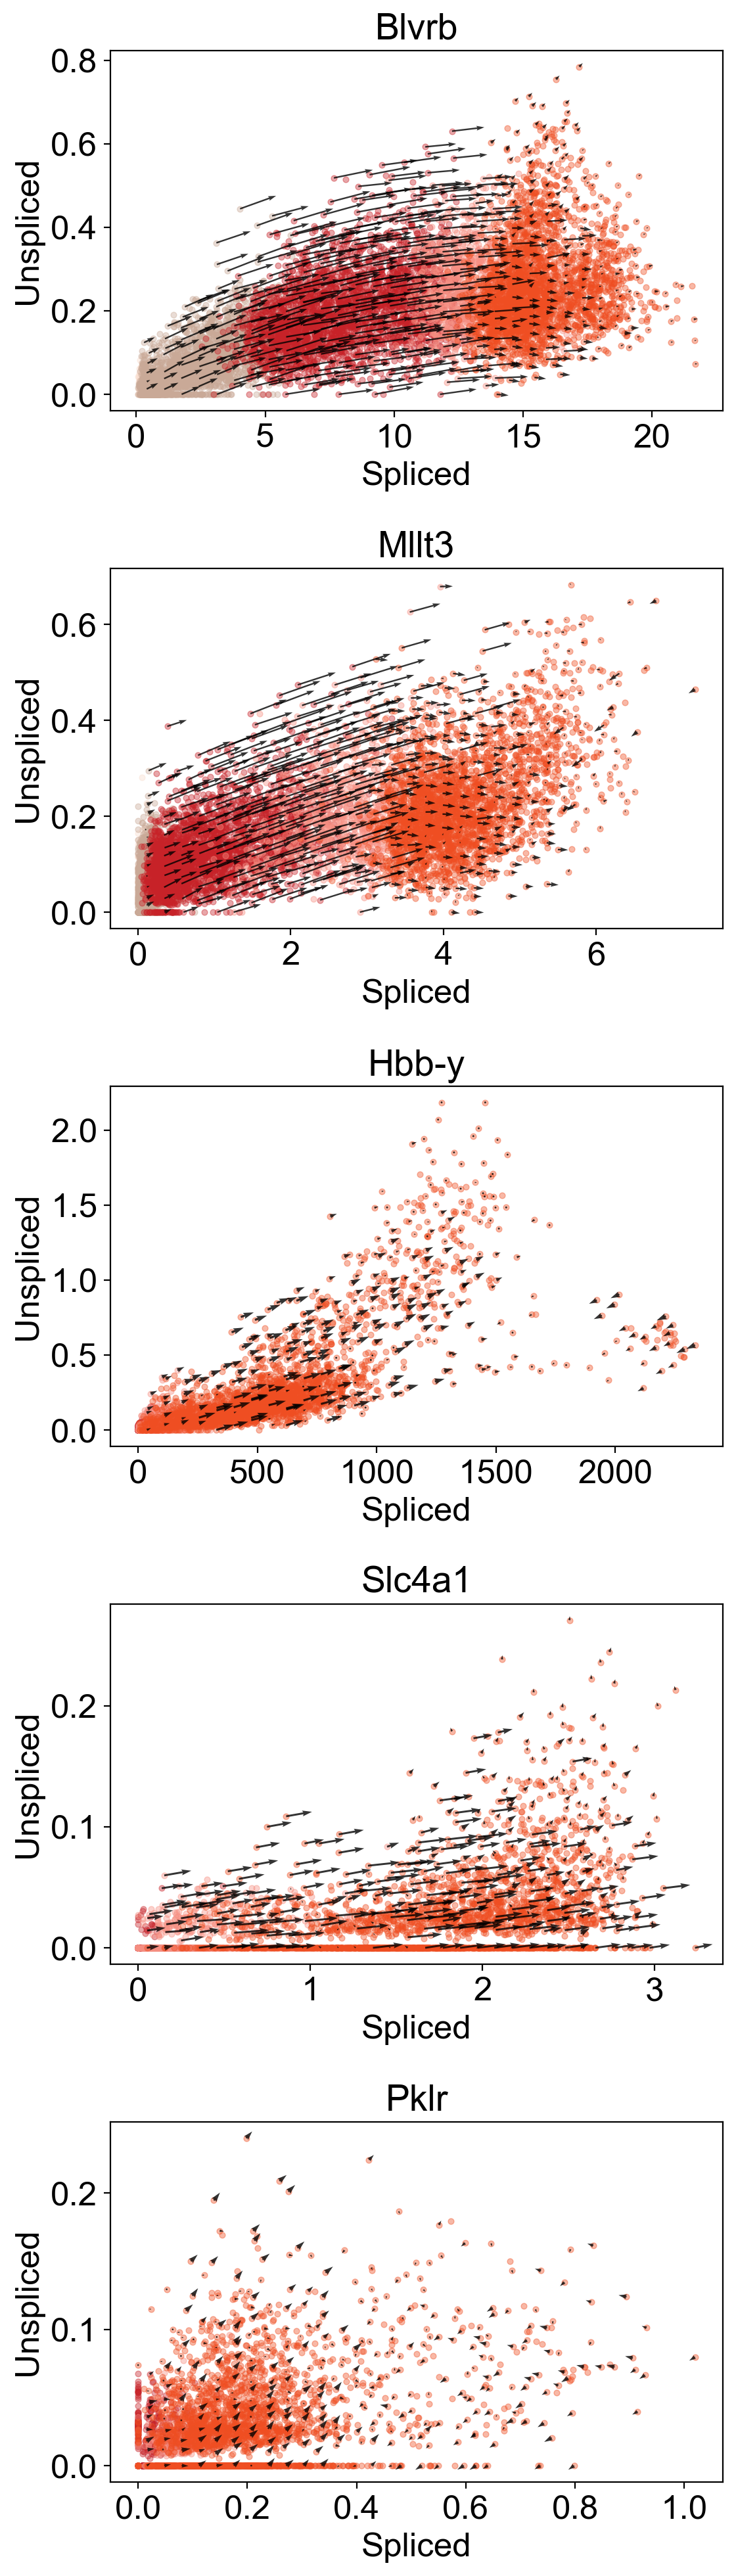

In [38]:
others = ['Blvrb', 'Mllt3', 'Hbb-y', 'Slc4a1', 'Pklr']
kwargs = {'genes': others, 'color': 'celltype', 
          'pointsize': 10, 'ncols': 1, 'scale': 1, 'downsample': 0.1, 'quiver_alpha': 0.8, 'show': False}
ax = plot_velocity_phase(adata_dyn, **kwargs)
plt.savefig(str(FIG_DIR)+'/suppl_figures_mouse_ery/other_murk.pdf', dpi=300, transparent=True)
plt.show()